In [214]:
import os
import os.path as osp
import pprint
import random
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import skimage.io
import skimage.transform
import torch
import yaml
from docopt import docopt
import scipy.io as sio

import lcnn
from lcnn.config import C, M
from lcnn.models.line_vectorizer import LineVectorizer
from lcnn.models.multitask_learner import MultitaskHead, MultitaskLearner
from lcnn.models.HT import hough_transform

from lcnn.postprocess import postprocess
from lcnn.utils import recursive_to
import cv2
from IPython.display import Image, display

In [215]:
REJECT_DEGREE_TH = 40.0

In [216]:
PLTOPTS = {"color": "#33FFFF", "s": 15, "edgecolors": "none", "zorder": 5}
cmap = plt.get_cmap("jet")
norm = mpl.colors.Normalize(vmin=0.9, vmax=1.0)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

In [217]:
def c(x):
    return sm.to_rgba(x)

In [218]:
config_file = "config/wireframe.yaml"
C.update(C.from_yaml(filename=config_file))
M.update(C.model)
pprint.pprint(C, indent=4)

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

{   'io': {   'datadir': 'data/wireframe/',
              'logdir': 'logs/',
              'num_workers': 4,
              'outdir': 'results/',
              'resume_from': None,
              'tensorboard_port': 0,
              'validation_interval': 20000,
              'vote_index': 'vote_index_128_128_3_1.mat'},
    'model': {   'backbone': 'stacked_hourglass',
                 'batch_size': 5,
                 'batch_size_eval': 2,
                 'depth': 4,
                 'dim_fc': 1024,
                 'dim_loi': 128,
                 'eval_junc_thres': 0.008,
                 'head_size': <BoxList: [[2], [1], [2]]>,
                 'image': {   'mean': <BoxList: [109.73, 103.832, 98.681]>,
                              'stddev': <BoxList: [22.275, 22.124, 23.229]>},
                 'loss_weight': {   'jmap': 8.0,
                                    'joff': 0.25,
                                    'lmap': 0.5,
                                    'lneg': 1,
            

In [219]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device_name = "cpu"
torch.backends.cudnn.deterministic = True
torch.cuda.manual_seed(0)
print("Let's use", torch.cuda.device_count(), "GPU(s)!")

Let's use 0 GPU(s)!


In [220]:
device = torch.device(device_name)
checkpoint = torch.load("pretrained_models/ht_lcnn/checkpoint.pth.tar", map_location=device)


In [221]:
# Load model
if os.path.isfile(C.io.vote_index):
    vote_index = sio.loadmat(C.io.vote_index)['vote_index']
else:
    vote_index = hough_transform(rows=128, cols=128, theta_res=3, rho_res=1)
    sio.savemat(C.io.vote_index, {'vote_index': vote_index})
vote_index = torch.from_numpy(vote_index).float().contiguous().to(device)
print('load vote_index', vote_index.shape)

load vote_index torch.Size([128, 128, 182, 60])


In [222]:
model = lcnn.models.hg(
    depth=M.depth,
    head=lambda c_in, c_out: MultitaskHead(c_in, c_out),
    num_stacks=M.num_stacks,
    num_blocks=M.num_blocks,
    num_classes=sum(sum(M.head_size, [])),
    vote_index=vote_index,

)
model = MultitaskLearner(model)
model = LineVectorizer(model)
model.load_state_dict(checkpoint["model_state_dict"])
model = model.to(device)
model.eval()

LineVectorizer(
  (backbone): MultitaskLearner(
    (backbone): HourglassNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (relu): ReLU(inplace=True)
      (layer1): Sequential(
        (0): Bottleneck2D(
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
          (relu): ReLU(inplace=True)
          (downsample): Sequential(
            (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
      )
      (layer2): Sequential(
        (0): Bottleneck2D(
          (bn

In [223]:
img = "pictures/01.png"
print(f"Processing {img}")
im = skimage.io.imread(img)
# cv2.imshow("img",im)
# cv2.waitKey(0) 
# display(Image(im))

Processing pictures/01.png


In [224]:
if im.ndim == 2:
    im = np.repeat(im[:, :, None], 3, 2)
im = im[:, :, :3]
im_resized = skimage.transform.resize(im, (512, 512)) * 255
image = (im_resized - M.image.mean) / M.image.stddev
# cv2.imshow("img",image)
# cv2.waitKey(0) 
image = torch.from_numpy(np.rollaxis(image, 2)[None].copy()).float()

In [225]:
# cv2.imshow("img",image)
# cv2.waitKey(0) 

In [226]:
with torch.no_grad():
    input_dict = {
        "image": image.to(device),
        "meta": [
            {
                "junc": torch.zeros(1, 2).to(device),
                "jtyp": torch.zeros(1, dtype=torch.uint8).to(device),
                "Lpos": torch.zeros(2, 2, dtype=torch.uint8).to(device),
                "Lneg": torch.zeros(2, 2, dtype=torch.uint8).to(device),
            }
        ],
        "target": {
            "jmap": torch.zeros([1, 1, 128, 128]).to(device),
            "joff": torch.zeros([1, 1, 2, 128, 128]).to(device),
        },
        "mode": "testing",
    }
    H = model(input_dict)["preds"]

In [227]:
lines = H["lines"][0].cpu().numpy() / 128 * im.shape[:2]
scores = H["score"][0].cpu().numpy()
print('lines: ',lines, ', scores: ', scores)
for i in range(1, len(lines)):
    if (lines[i] == lines[0]).all():
        lines = lines[:i]
        scores = scores[:i]
        break

lines:  [[[ 296.62046313 1357.41897583]
  [ 236.12358749 1367.06737518]]

 [[ 714.98130798 1775.24139404]
  [ 194.94132042 1183.35033417]]

 [[ 703.05009127  216.47910118]
  [ 199.05102253  791.38790131]]

 ...

 [[ 710.62550783 1566.69296265]
  [ 229.62587178 1160.1531601 ]]

 [[ 194.3230176  1537.28645325]
  [ 296.77264094 1444.86156464]]

 [[ 286.34405136 1416.77570343]
  [ 237.59344876 1627.06581116]]] , scores:  [0.99956626 0.9995142  0.99944407 ... 0.8604378  0.86006624 0.8591204 ]


In [228]:

# postprocess lines to remove overlapped lines
diag = (im.shape[0] ** 2 + im.shape[1] ** 2) ** 0.5
nlines, nscores = postprocess(lines, scores, diag * 0.01, 0, False)

In [229]:
type(nlines)

numpy.ndarray

In [230]:
def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and b2,b1.
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

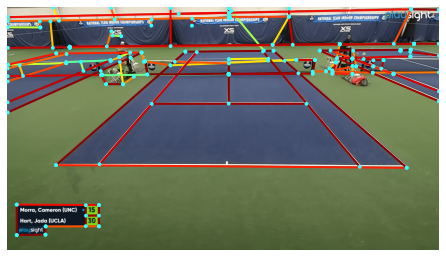

In [231]:
t = 0.94
im2 = np.copy(im)
plt.gca().set_axis_off()
plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
plt.margins(0, 0)
for (a, b), s in zip(nlines, nscores):
    if s < t:
        continue
    plt.plot([a[1], b[1]], [a[0], b[0]], c=c(s), linewidth=2, zorder=s)
    plt.scatter(a[1], a[0], **PLTOPTS)
    plt.scatter(b[1], b[0], **PLTOPTS)
    cv2.line(im2, (int(a[1]), int(a[0])), (int(b[1]), int(b[0])), (255, 255, 255), thickness=2)
plt.gca().xaxis.set_major_locator(plt.NullLocator())
plt.gca().yaxis.set_major_locator(plt.NullLocator())
plt.imshow(im)
plt.show()
plt.close()


In [232]:
cv2.imshow("OutputImage", im2)
cv2.waitKey(0)
cv2.destroyAllWindows()
cv2.imwrite('pictures/test.jpg', im2)


True

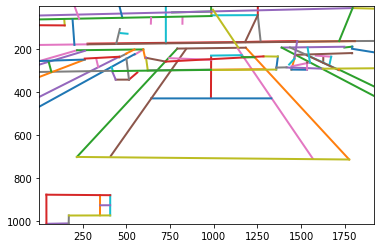

In [233]:
t = 0.94
plt.figure(1)
plt.margins(0, 0)
nlines2 = []
for (a, b), s in zip(nlines, nscores):
    if s < t:
        continue
    nlines2.append((a,b))
    plt.plot([a[1], b[1]], [a[0], b[0]], linewidth=2)
nlines2 = np.array(nlines2)
plt.gca().invert_yaxis()
plt.show()
plt.close()

(array([12.,  5.,  3.,  8., 17., 50.,  7.,  3.,  3., 16.]), array([8.28274569e-02, 1.80610555e+01, 3.60392836e+01, 5.40175116e+01,
       7.19957397e+01, 8.99739677e+01, 1.07952196e+02, 1.25930424e+02,
       1.43908652e+02, 1.61886880e+02, 1.79865108e+02]), <BarContainer object of 10 artists>)


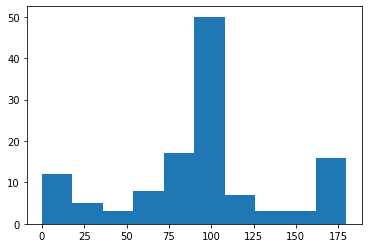

In [234]:
line_w_thetas = []
thetas=[]
for line in nlines2:
    if line[0][1]>line[1][1]:
        dy = line[0][1]-line[1][1]
        dx = line[0][0]-line[1][0]
    else:
        dy = line[1][1]-line[0][1]
        dx = line[1][0]-line[0][0]        

    theta = math.atan2(dy,dx)
    theta *= 180/math.pi
    line_w_thetas.append([line,theta])
    thetas.append(theta)
    # print (theta)
thetas.sort()
# print(thetas)
# np.gradient(thetas)
result = plt.hist(thetas)
print(result)

In [235]:
line_w_thetas[0][0]

array([[ 296.62046313, 1357.41897583],
       [ 236.12358749, 1367.06737518]])

In [236]:
res = np.copy(result[0])
print(res)
ind1=np.argmax(res)
res[ind1] =0
ind2 = np.argmax(res)
print(ind1,ind2)
print(result[1][ind1],result[1][ind2])
filter_th = [int(result[1][ind1]),int(result[1][ind2])]
print(filter_th)


[12.  5.  3.  8. 17. 50.  7.  3.  3. 16.]
5 4
89.97396771257557 71.99573966144116
[89, 71]


In [237]:
intersect_points = []
for i in range(len(nlines2)):
    for j in range(i+1,len(nlines2)):
        inter = get_intersect(nlines2[i][0],nlines2[i][1],nlines2[j][0],nlines2[j][1])
        if abs(inter[0])< im.shape[0] and abs(inter[1])< im.shape[1]:
            intersect_points.append(inter)

In [238]:
intersect_points[0]

(341.5794508690013, 1350.248650692286)

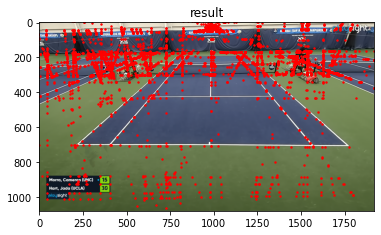

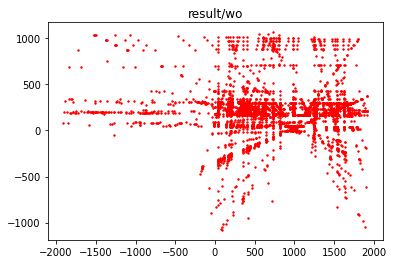

In [239]:
plt.figure(1)
plt.title('result')
plt.scatter([i[1] for i in intersect_points],[i[0] for i in intersect_points],c='r',s=2)
# plt.gca().invert_yaxis()
plt.imshow(im)
plt.figure(2)
plt.title('result/wo')
plt.scatter([i[1] for i in intersect_points],[i[0] for i in intersect_points],c='r',s=2)

In [240]:
def add_court_overlay(frame, homography, overlay_color=(255, 255, 255)):
    court_reference = cv2.imread("pictures/court_reference.png", 0)
    court = cv2.warpPerspective(court_reference, homography, (frame.shape[1],frame.shape[0]))
    # court = cv2.warpPerspective(court_reference, homography, frame.shape[1::-1])
    frame[court == 255, :] = overlay_color
    return frame

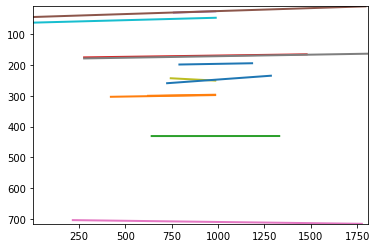

In [241]:
plt.figure(1)
plt.margins(0, 0)
for (a, b), s in zip(nlines, nscores):
    if s < t:
        continue
    if(abs(a[0] - b[0]) < abs(a[1] - b[1]) and \
            ((a[1] - im.shape[1] / 2) * (b[1] - im.shape[1] / 2)) < 0):
        plt.plot([a[1], b[1]], [a[0], b[0]], linewidth=2)
plt.gca().invert_yaxis()
 

In [242]:
# t = 0.94
# plt.gca().set_axis_off()
# plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=0)
# plt.margins(0, 0)

# new_nlines = np.zeros((2,2,2))
# new_nscores = np.zeros((2))
# bottom_1 = -1
# bottom_2 = -1
# for (a, b), s in zip(nlines, nscores):
#     if s < t:
#         continue
    
#     # is horizontal
#     # has a point in the middle of the image
#     if(abs(a[0] - b[0]) < abs(a[1] - b[1]) and \
#             ((a[1] - im.shape[1] / 2) * (b[1] - im.shape[1] / 2)) < 0):
#         min_bottom = min(bottom_1, bottom_2)
#         if a[0] > min_bottom and b[0] > min_bottom:
#             if(bottom_1 == min_bottom):
#                 bottom_1 = (a[0]+b[0])/2
#                 new_nlines[0][0] = a
#                 new_nlines[0][1] = b
#                 new_nscores[0] = s
#             else:
#                 bottom_2 = (a[0]+b[0])/2
#                 new_nlines[1][0] = a
#                 new_nlines[1][1] = b
#                 new_nscores[1] = s

# court_points = new_nlines.copy()
# if(court_points[0][0][0] > court_points[1][0][0]):
#     court_points = np.flip(court_points, 0)
# for i, p in enumerate(court_points):
#     court_points[i] = np.flip(court_points[i], 1)
# for i, p in enumerate(court_points):
#     court_points[i] = p[p[:, 0].argsort()]
# # print(court_points)
# court_points = court_points.reshape(-1, new_nlines.shape[-1])

# court_points_new = court_points

# print("----------------------------")
# print(court_points)
# print(court_points_new)
# print("----------------------------")

# template_points = np.asarray([[147, 1839], [970, 1839], [10, 2388], [1107, 2388]])
# # T, _, _ = best_fit_transform(template_points, court_points)
# T, status = cv2.findHomography(template_points, np.asarray(court_points_new))
# plt.imshow(im)
# plt.show()
# plt.imshow(T)
# plt.show()
# court = add_court_overlay(im, T, overlay_color=(255, 0, 0))
# for c in court_points_new:
#     cv2.circle(court, (int(c[0]), int(c[1])), 3, (255,0,0), cv2.FILLED)
# # court = cv2.cvtColor(court, cv2.COLOR_RGB2BGR)
# plt.imshow(court)
# plt.show()

In [243]:
def GetVanishingPoint(Lines):
    # We will apply RANSAC inspired algorithm for this. We will take combination 
    # of 2 lines one by one, find their intersection point, and calculate the 
    # total error(loss) of that point. Error of the point means root of sum of 
    # squares of distance of that point from each line.
    VanishingPoint = None
    MinError = 100000000000

    for i in range(len(Lines)):
        for j in range(i+1, len(Lines)):
            m1, c1 = Lines[i][4], Lines[i][5]
            m2, c2 = Lines[j][4], Lines[j][5]

            if m1 != m2:
                x0 = (c1 - c2) / (m2 - m1)
                y0 = m1 * x0 + c1

                err = 0
                for k in range(len(Lines)):
                    m, c = Lines[k][4], Lines[k][5]
                    m_ = (-1 / m)
                    c_ = y0 - m_ * x0

                    x_ = (c - c_) / (m_ - m)
                    y_ = m_ * x_ + c_

                    l = math.sqrt((y_ - y0)**2 + (x_ - x0)**2)

                    err += l**2

                err = math.sqrt(err)

                if MinError > err:
                    MinError = err
                    VanishingPoint = [x0, y0]
                
    return VanishingPoint

In [244]:
def FilterLines(Lines):
    FinalLines = []
    
    for Line in Lines:
        [[x1, y1], [x2, y2]] = Line

        # Calculating equation of the line: y = mx + c
        if x1 != x2:
            m = (y2 - y1) / (x2 - x1)
        else:
            m = 100000000
        c = y2 - m*x2
        # theta will contain values between -90 -> +90. 
        theta = math.degrees(math.atan(m))

        # Rejecting lines of slope near to 0 degree or 90 degree and storing others
        if REJECT_DEGREE_TH <= abs(theta) <= (90 - REJECT_DEGREE_TH):
            l = math.sqrt( (y2 - y1)**2 + (x2 - x1)**2 )    # length of the line
            FinalLines.append([x1, y1, x2, y2, m, c, l])

    
    # Removing extra lines 
    # (we might get many lines, so we are going to take only longest 15 lines 
    # for further computation because more than this number of lines will only 
    # contribute towards slowing down of our algo.)
    if len(FinalLines) > 15:
        FinalLines = sorted(FinalLines, key=lambda x: x[-1], reverse=True)
        FinalLines = FinalLines[:15]
    
    return FinalLines

In [245]:
def FilterLines2(Lines):
    FinalLines = []
    
    for Line in Lines:
        [[x1, y1], [x2, y2]] = Line[0]
        theta = Line[1]
        # Rejecting lines of slope near to 0 degree or 90 degree and storing others
        if  filter_th[0]-REJECT_DEGREE_TH<= theta <=filter_th[0]+REJECT_DEGREE_TH \
        or filter_th[1]-REJECT_DEGREE_TH<= theta <=filter_th[1]+REJECT_DEGREE_TH:
            l = math.sqrt( (y2 - y1)**2 + (x2 - x1)**2 )    # length of the line
            FinalLines.append([x1, y1, x2, y2, theta, l])

    
    return FinalLines

In [246]:
print(line_w_thetas[0][0])
[[x1, y1], [x2, y2]] = line_w_thetas[0][0]
print(x1,y1,x2,y2)

[[ 296.62046313 1357.41897583]
 [ 236.12358749 1367.06737518]]
296.6204631328583 1357.4189758300781 236.1235874891281 1367.0673751831055


In [247]:
LineSS = FilterLines2(line_w_thetas)
print(LineSS[0])

[714.9813079833984, 1775.2413940429688, 194.94132041931152, 1183.3503341674805, 48.697214535193936, 787.8937843555974]


In [248]:
# Drawing lines and vanishing point
im3 = np.copy(im)
lines32 = np.float32(LineSS)
print(lines32[0])
for Line in lines32:
    cv2.line(im3, (Line[1], Line[0]), (Line[3], Line[2]), (0, 255, 0), 2)
# cv2.circle(im3, (int(VanishingPoint[0]), int(VanishingPoint[1])), 10, (0, 0, 255), -1)

# Showing the final image
cv2.imshow("OutputImage", im3)
cv2.waitKey(0)
cv2.destroyAllWindows()

[ 714.9813   1775.2415    194.94131  1183.3503     48.697216  787.8938  ]


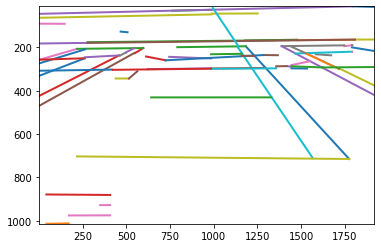

In [249]:
# Drawing lines and vanishing point
plt.figure(2)
plt.margins(0, 0)
lines32 = np.float32(LineSS)
for Line in lines32:
    # cv2.line(im, (Line[0], Line[1]), (Line[2], Line[3]), (0, 255, 0), 2)
    plt.plot((Line[1], Line[3]), (Line[0], Line[2]), linewidth=2)
# plt.scatter(VanishingPoint[0], VanishingPoint[1],**PLTOPTS)    
    # Showing the final imageplt.gca().invert_yaxis()
plt.gca().invert_yaxis()

In [250]:
GrayImage = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
#Blurring image to reduce noise.
BlurGrayImage = cv2.GaussianBlur(GrayImage, (5, 5), 1)
# Generating Edge image
EdgeImage = cv2.Canny(BlurGrayImage, 40, 255)

# Finding Lines in the image
Lines = cv2.HoughLinesP(EdgeImage, 1, np.pi / 180, 50, 10, 15)

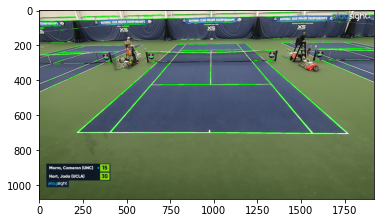

In [251]:
im4 = np.copy(im)
for Line in Lines:
    Line = Line[0]
    cv2.line(im4,(Line[0], Line[1]), (Line[2], Line[3]), (0, 255, 0), 2)
# cv2.circle(im, (int(VanishingPoint[0]), int(VanishingPoint[1])), 10, (0, 0, 255), -1)
cv2.imshow("OutputImage", im4)
cv2.waitKey(0)
cv2.destroyAllWindows()
plt.imshow(im4)
plt.show()
plt.close()

In [252]:
def calculate_metric_angle(current_hypothesis, lines, ignore_pts, ransac_angle_thresh):
    current_hypothesis = current_hypothesis / current_hypothesis[-1]
    hypothesis_vp_direction = current_hypothesis[:2] - lines[:,0]
    lines_vp_direction = lines[:,1] - lines[:,0]
    magnitude = np.linalg.norm(hypothesis_vp_direction, axis=1) * np.linalg.norm(lines_vp_direction, axis=1)
    magnitude[magnitude == 0] = 1e-5
    cos_theta = (hypothesis_vp_direction*lines_vp_direction).sum(axis=-1) / magnitude
    cos_theta = np.clip(cos_theta, -1, 1)
    theta = np.arccos(np.abs(cos_theta))
    inliers = (theta < ransac_angle_thresh * np.pi / 180)
    inliers[ignore_pts] = False
    return inliers, inliers.sum()

In [253]:
def run_line_ransac(lines, ransac_iter, ransac_angle_thresh, ignore_pts=None):
    best_vote_count = 0
    best_inliers = None
    best_hypothesis = None
    if ignore_pts is None:
        ignore_pts = np.zeros((lines.shape[0])).astype('bool')
        lines_to_chose = np.arange(lines.shape[0])
    else:
        lines_to_chose = np.where(ignore_pts==0)[0]
    for iter_count in range(ransac_iter):
        idx1, idx2 = np.random.choice(lines_to_chose, 2, replace=False)
        l1 = np.cross(np.append(lines[idx1][1], 1), np.append(lines[idx1][0], 1))
        l2 = np.cross(np.append(lines[idx2][1], 1), np.append(lines[idx2][0], 1))

        current_hypothesis = np.cross(l1, l2)
        if current_hypothesis[-1] == 0:
            continue
        inliers, vote_count = calculate_metric_angle(current_hypothesis, lines, ignore_pts, ransac_angle_thresh)
        if vote_count > best_vote_count:
            best_vote_count = vote_count
            best_hypothesis = current_hypothesis
            best_inliers = inliers
    return best_hypothesis, best_inliers

In [254]:
def get_vp_inliers(nlines, iterations, threshold):

    best_hypothesis_1, best_inliers_1 = run_line_ransac(nlines, iterations, threshold)
    ignore_pts = best_inliers_1
    best_hypothesis_2, best_inliers_2 = run_line_ransac(nlines, iterations, threshold, ignore_pts=ignore_pts)
    ignore_pts = np.logical_or(best_inliers_1, best_inliers_2)
    best_hypothesis_3, best_inliers_3 = run_line_ransac(nlines, iterations, threshold, ignore_pts=ignore_pts)
    inlier_lines_list = [best_inliers_1, best_inliers_2, best_inliers_3]
    best_hypothesis_1 = best_hypothesis_1 / best_hypothesis_1[-1]
    best_hypothesis_2 = best_hypothesis_2 / best_hypothesis_2[-1]
    best_hypothesis_3 = best_hypothesis_3 / best_hypothesis_3[-1]
    hypothesis_list = [best_hypothesis_1, best_hypothesis_2, best_hypothesis_3]
    return inlier_lines_list, hypothesis_list

In [255]:
def visualize_inliers(image, lines, inlier_lines_list, colors, fig_name='detected_lines.png'):
    subplot_count = len(inlier_lines_list)

    fig, axes = plt.subplots(1, subplot_count, figsize=(15, 15), sharex=True, sharey=True)
    ax = axes.ravel()
    for i in range(len(inlier_lines_list)):
        ax[i].imshow(im)
        for line in lines[inlier_lines_list[i]]:
            p0, p1 = line
            ax[i].plot((p0[1], p1[1]),(p0[0], p1[0]), colors[i])
        ax[i].set_xlim((0, image.shape[1]))
        ax[i].set_ylim((image.shape[0], 0))
        ax[i].set_title('RANSAC {} Inliers'.format(str(i)))

    for a in ax:
        a.set_axis_off()

    plt.tight_layout() 
    plt.show()
    # plt.savefig(fig_name)
    plt.close()

    plt.figure(8)
    for i in range(len(inlier_lines_list)):
        plt.imshow(im)
        for line in lines[inlier_lines_list[i]]:
            p0, p1 = line
            plt.plot((p0[1], p1[1]),(p0[0], p1[0]), colors[i])


    plt.tight_layout() 
    plt.show()
    # plt.savefig(fig_name)
    plt.close()

In [256]:
def visualize_vanishing_points(vp1, vp2, vp3, image, lines, inlier_lines_list, colors):
    vps = [vp1, vp2, vp3]
    for i in range(len(inlier_lines_list)):
        plt.imshow(image)
        for line in lines[inlier_lines_list[i]]:
            p0, p1 = line
            plt.plot((p0[0], p1[0]), (p0[1], p1[1]), colors[i])

        plt.plot([vps[i][0]], [vps[i][1]], colors[i]+'X', markersize=5)
        plt.axis('off')
        plt.tight_layout()
        plt.close()

    plt.imshow(image)
    for i in range(len(inlier_lines_list)):
        for line in lines[inlier_lines_list[i]]:
            p0, p1 = line
            plt.plot((p0[0], p1[0]), (p0[1], p1[1]), colors[i])

    plt.plot([vps[0][0]], [vps[0][1]], colors[0]+'X', markersize=5)
    plt.plot([vps[1][0]], [vps[1][1]], colors[1]+'X', markersize=5)
    plt.plot([vps[2][0]], [vps[2][1]], colors[2]+'X', markersize=5)
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    plt.close() 

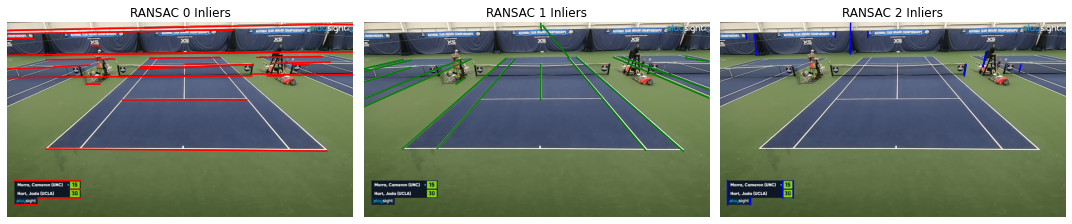

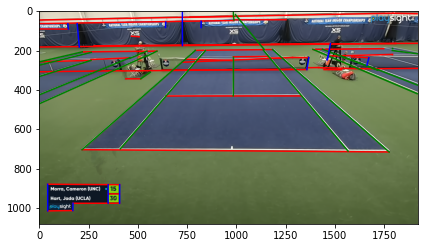

In [257]:
inlier_lines_list, hypothesis_list = get_vp_inliers(nlines2,1000, 5)
best_hypothesis_1, best_hypothesis_2, best_hypothesis_3 = hypothesis_list
colors = ['r', 'g', 'b']
visualize_inliers(im, nlines2, inlier_lines_list, colors)
visualize_vanishing_points(best_hypothesis_1, best_hypothesis_2, best_hypothesis_3,
                               im, nlines2, inlier_lines_list, colors)

In [258]:
def rotateHToLine(H, line):
    assert len(line) == 3
    assert H.shape[0] == 3 and H.shape[1] == 3

    # Compute transformed line = H^-T * l
    lineTr = np.dot(np.linalg.inv(H).T, line)

    # Rotate so that this line is horizonal in the image 
    r1 = np.array([lineTr[1], -lineTr[0]]) # First row of R is perpendicular to linesTr[0]
    r1 = r1 / np.linalg.norm(r1.flatten())
    theta = np.arctan2(-r1[1] , r1[0])
    if abs(theta) < pi/4:
        R = np.array([[r1[0],  r1[1]], [-r1[1], r1[0]]])
    else:
        R = np.identity(2)
        #R = np.array([[r1[1], -r1[0]], [ r1[0], r1[1]]])
    theta = np.arctan2(R[1,0], R[1,1])
    print("Rotating by %.1f degrees" % (theta*180/pi))
    HR = np.identity(3)
    HR[0:2,0:2] = R

    return np.dot(HR,H)

In [259]:
def translateHToPosQuadrant(H, limits):
    assert len(limits) >= 2 # can have color channels
    assert limits[0] > 0 and limits[1] > 0
    assert H.shape[0] == 3 and H.shape[1] == 3

    # Get H * image corners
    Hcor, finite = getHCorners(H, limits)

    # Check if corners map to infinity, if so skip translation
    if not finite:
        print("Corners map to infinity, skipping translation")
        return H

    # Min coordinates of H * image corners
    minc = [min([Hcor[j][i]/Hcor[j][2] for j in range(len(Hcor))]) for i in range(2)]

    # Choose translation
    HT = np.identity(3)
    HT[0,2] = -minc[0]
    HT[1,2] = -minc[1]

    return np.dot(HT, H)

In [260]:
def scaleHToImage(H, limits, anisotropic = False): # TODO: test anisotropic
    assert len(limits) >= 2 # can have color channels
    assert limits[0] > 0 and limits[1] > 0
    assert H.shape[0] == 3 and H.shape[1] == 3

    # Get H * image corners
    Hcor, finite = getHCorners(H, limits)

    # If corners in the transformed image are not finite, don't do scaling
    if not finite:
        print("Skipping scaling due to point mapped to infinity")
        return H;
        
    # Maximum coordinate that any corner maps to
    k = [max([Hcor[j][i] / Hcor[j][2] for j in range(len(Hcor))])/float(limits[1-i]) for i in range(2)];

    # Scale
    if anisotropic:
        print("Scaling by (%f,%f)\n" % (k[0], k[1]))
        HS = np.array([[1./k[0],0.0,0.0],[0.0,1./k[1],0.0],[0.0,0.0,1.0]])
    else:
        k = max(k)
        print("Scaling by %f\n" % k)
        HS = np.array([[1.0/k,0.0,0.0],[0.0,1.0/k,0.0],[0.0,0.0,1.0]])

    return np.dot(HS, H)

In [261]:
def getHCorners(H, limits):
    Ny = float(limits[0])
    Nx = float(limits[1])
    # Apply H to corners of the image to determine bounds
    Htr  = np.dot(H, np.array([0.0, Ny, 1.0]).flatten()) # Top left maps to here
    Hbr  = np.dot(H, np.array([Nx,  Ny, 1.0]).flatten()) # Bottom right maps to here
    Hbl  = np.dot(H, np.array([Nx, 0.0, 1.0]).flatten()) # Bottom left maps to here
    Hcor = [Htr,Hbr,Hbl]
    
    # Check if corners in the transformed image map to infinity finite
    finite = True 
    for y in Hcor:
        if y[2] == 0:
            finite = False

    return Hcor, finite

In [262]:
vLine = np.cross(best_hypothesis_1, best_hypothesis_2)
print(best_hypothesis_1,best_hypothesis_2)
print("Vanishing line:")
print(vLine)
H = np.identity(3)
H[2,0] = vLine[0] / vLine[2]
H[2,1] = vLine[1] / vLine[2]

print("H:")
print(H)



[-3.98375643e+02 -9.26739412e+04  1.00000000e+00] [ 18.14336598 985.64903757   1.        ]
Vanishing line:
[-9.36595902e+04  4.16519009e+02  1.28875866e+06]
H:
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [-7.26742663e-02  3.23193955e-04  1.00000000e+00]]


In [263]:

# H = rotateHToLine(H, [inlier_lines_list[0],1])
H = translateHToPosQuadrant(H, im.shape)
H = scaleHToImage(H, im.shape, False)


Scaling by 0.748499



In [264]:
result = cv2.warpPerspective(im, H, (im.shape[1], im.shape[0]))
cv2.imshow('output',result) 
cv2.imwrite('output.png',result)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [265]:
im_cv = cv2.imread(img)
padding = 100
im_cv= cv2.copyMakeBorder(im_cv,padding,padding,padding,padding,cv2.BORDER_CONSTANT,value=[255,255,255])
list1 = []      # separate lists to store the coordinates for the separate lines
list2 = []
check = 0       # variable to switch between the lists

def getPoints(event, x, y, flags, params):
    
    global list1, list2, check    
   
    if event == cv2.EVENT_LBUTTONDOWN:
        print (x,y)
        if check < 4:
            list1.append([x, y])
            check += 1
        else:
            list2.append([x, y])
    elif event == cv2.EVENT_LBUTTONUP:                   
        cv2.circle(im_cv,(x,y), 4, (0,255,0), -1)
        cv2.imshow("image", im_cv)

    
cv2.namedWindow("image")
cv2.setMouseCallback("image", getPoints)

def selectPoints():
    global check
    while True:
        cv2.imshow("image", im_cv)
        key = cv2.waitKey(1) & 0xFF        
        
        if key == ord("q"):
            break
#         elif check == 7:
#             break
        
selectPoints()
cv2.destroyAllWindows()
cv2.waitKey(1)

1287 290
891 295
315 802
1875 808


-1

In [266]:
width_AD = np.sqrt(((list1[0][0] - list1[3][0]) ** 2) + ((list1[0][1] - list1[3][1]) ** 2))
width_BC = np.sqrt(((list1[1][0] - list1[2][0]) ** 2) + ((list1[1][1] - list1[2][1]) ** 2))
maxWidth = max(int(width_AD), int(width_BC))


height_AB = np.sqrt(((list1[0][0] - list1[1][0]) ** 2) + ((list1[0][1] - list1[1][1]) ** 2))
height_CD = np.sqrt(((list1[2][0] - list1[3][0]) ** 2) + ((list1[2][1] - list1[3][1]) ** 2))
maxHeight = max(int(height_AB), int(height_CD))
output_pts = np.float32([[0, 0],
                        [0, maxHeight - 1],
                        [maxWidth - 1, maxHeight - 1],
                        [maxWidth - 1, 0]])

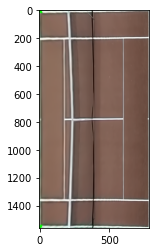

In [267]:
width , height = 350 , 550
list11 = np.float32(list1) 
# list22 = np.float32([[0,0],[width,0],[0,height],[width,height]])
matrix = cv2.getPerspectiveTransform(list11,output_pts)
output = cv2.warpPerspective(im_cv,matrix,(maxWidth,maxHeight))
# cv2.imshow('output',output) 
cv2.imwrite('output.png',output)
cv2.waitKey(0)
cv2.destroyAllWindows()

plt.imshow(output)
plt.show()
plt.close()

In [268]:
print(matrix)

[[-9.58484466e-02 -7.59119697e+00  2.32480407e+03]
 [ 4.86920787e+00 -5.52720893e+00 -4.66377994e+03]
 [-1.32044080e-04 -7.24372212e-03  1.00000000e+00]]


(2408, 1127)


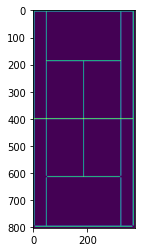

In [269]:
template_points = np.asarray([[147, 1839], [970, 1839], [10, 2388], [1107, 2388]])
court_reference = cv2.imread("pictures/court_reference.png", 0)
print(court_reference.shape)
for c in template_points:
    cv2.circle(court_reference, (int(c[0]), int(c[1])), 10, (0,255,0), cv2.FILLED)
imS = cv2.resize(court_reference, (int(court_reference.shape[1]/3), int(court_reference.shape[0]/3)))
# cv2.imshow("Court", imS)
# cv2.waitKey(0)
# cv2.destroyAllWindows()
plt.imshow(imS)
plt.show()
plt.close()

In [270]:
court_reference.shape

(2408, 1127)

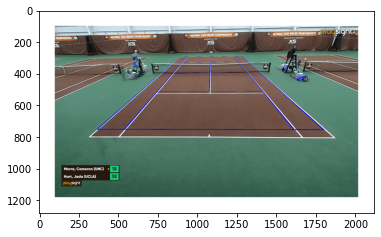

In [271]:
im5 = np.copy(im)
padding = 100
im5= cv2.copyMakeBorder(im5,padding,padding,padding,padding,cv2.BORDER_CONSTANT,value=[255,255,255])
# list1 = np.asarray([[219, 702],[1769, 707],[1186, 194],[794, 198]]) 
factor = 2.18
template_try= np.asarray([[0, 0], [2408/factor, 0], [2408/factor, 1127*factor], [0, 1127*factor]])
T, status = cv2.findHomography(template_try, np.asarray(list1))
court = add_court_overlay(im5, T, overlay_color=(255, 0, 0))
# for c in court_points_new:
#     cv2.circle(court, (int(c[0]), int(c[1])), 3, (255,0,0), cv2.FILLED)
court = cv2.cvtColor(court, cv2.COLOR_RGB2BGR)
cv2.imshow("Court", court)
cv2.waitKey(0)
cv2.destroyAllWindows()
plt.imshow(court)
plt.show()
plt.close()

In [311]:
def intersect(a1, a2, b1, b2):
    x1,y1 = a1
    x2,y2 = a2
    x3,y3 = b1
    x4,y4 = b2
    denom = (y4-y3)*(x2-x1) - (x4-x3)*(y2-y1)
    if denom == 0: # parallel
        return None
    ua = ((x4-x3)*(y1-y3) - (y4-y3)*(x1-x3)) / denom
    if ua < 0 or ua > 1: # out of range
        return None
    ub = ((x2-x1)*(y1-y3) - (y2-y1)*(x1-x3)) / denom
    if ub < 0 or ub > 1: # out of range
        return None
    x = x1 + ua * (x2-x1)
    y = y1 + ua * (y2-y1)
    return [x,y]

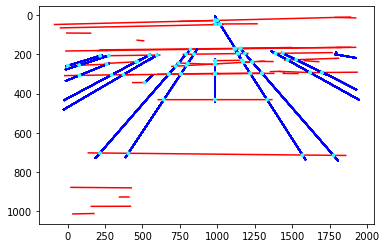

In [312]:
s_factor = 1.1
section = []
section_ind = []
inter_pts = []
for i,line1 in enumerate(nlines2[inlier_lines_list[0]]):
    a0,a1 = line1
    a0 = [a0[0] *(1+s_factor)/2 + a1[0] *(1-s_factor)/2 , a0[1] *(1+s_factor)/2 + a1[1] *(1-s_factor)/2]
    a1 = [a1[0] *(1+s_factor)/2 + a0[0] *(1-s_factor)/2 , a1[1] *(1+s_factor)/2 + a0[1] *(1-s_factor)/2]
    plt.plot((a0[1], a1[1]),(a0[0], a1[0] ), 'r')
    counter = 0
    for j,line2 in enumerate(nlines2[inlier_lines_list[1]]):
        b0,b1 = line2
        b0 = [b0[0] *(1+s_factor)/2 + b1[0] *(1-s_factor)/2 , b0[1] *(1+s_factor)/2 + b1[1] *(1-s_factor)/2]
        b1 = [b1[0] *(1+s_factor)/2 + b0[0] *(1-s_factor)/2 , b1[1] *(1+s_factor)/2 + b0[1] *(1-s_factor)/2]
        plt.plot((b0[1], b1[1]),(b0[0], b1[0] ), 'b')
        intersect_pt = intersect(a0,a1,b0,b1)
        # print (intersect_pt)
        if intersect_pt is not None:
            plt.scatter(intersect_pt[1],intersect_pt[0],**PLTOPTS)
            if(counter==0):
                section.append([line1,line2])
                section_ind.append([i,j+len(inlier_lines_list[0])])
                inter_pts.append([intersect_pt])
            else:
                section[-1].append(line2)
                section_ind[-1].append(j+len(inlier_lines_list[0]))
                inter_pts[-1].append(intersect_pt)
            counter +=1
            
plt.gca().invert_yaxis()
  
# for i in range(len(inlier_lines_list)-1):
#     plt.imshow(im)
#     for line in nlines2[inlier_lines_list[i]]:
#         p0, p1 = line
#         plt.plot((p0[1], p1[1]),(p0[0], p1[0] ), colors[i])

In [320]:
for i , n in enumerate(inter_pts):
    print(i,':', len(n))

0 : 5
1 : 3
2 : 2
3 : 1
4 : 3
5 : 3
6 : 3
7 : 2
8 : 2
9 : 3
10 : 2
11 : 3
12 : 4
13 : 4
14 : 4
15 : 2
16 : 1
17 : 3
18 : 1
19 : 3
20 : 5
21 : 2
22 : 3
23 : 2
24 : 3
25 : 2


In [314]:

merge_sec = section[0]
print(section_ind[0])
for current_sec in section_ind[1:]:
    print(current_sec)
    # for line in current_sec:
        # print(line)
    

[1, 124, 125, 129, 134, 150]
[2, 125, 126, 134]
[3, 130, 141]
[4, 146]
[7, 126, 129, 134]
[8, 124, 126, 129]
[13, 124, 126, 129]
[15, 124, 150]
[18, 130, 141]
[19, 128, 133, 142]
[21, 132, 138]
[23, 132, 138, 150]
[26, 124, 125, 129, 134]
[29, 127, 139, 144, 148]
[32, 124, 125, 129, 150]
[33, 138, 150]
[36, 130]
[37, 125, 126, 134]
[40, 150]
[42, 130, 140, 145]
[48, 124, 125, 126, 129, 134]
[50, 126, 129]
[51, 139, 142, 144]
[52, 124, 129]
[57, 125, 126, 134]
[58, 133, 147]


In [315]:
merged_ind = section_ind
out = []
while len(merged_ind)>0:
    first, *rest = merged_ind
    first = set(first)

    lf = -1
    while len(first)>lf:
        lf = len(first)

        rest2 = []
        for r in rest:
            if len(first.intersection(set(r)))>0:
                first |= set(r)
            else:
                rest2.append(r)     
        rest = rest2

    out.append(first)
    merged_ind = rest

print(out)

[{1, 129, 2, 132, 134, 7, 8, 138, 13, 15, 21, 150, 23, 26, 32, 33, 37, 40, 48, 50, 52, 57, 124, 125, 126}, {145, 130, 3, 18, 36, 42, 140, 141}, {146, 4}, {128, 133, 139, 142, 144, 19, 51, 147, 148, 58, 29, 127}]


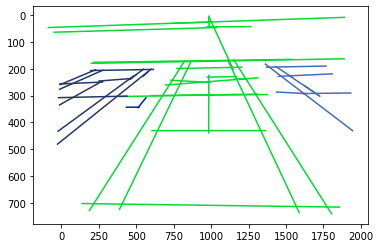

In [316]:
for sec in out:
    r = np.random.rand(3,)
    for line1 in sec:
        if line1< len(inlier_lines_list[0]):      
            a0,a1 = nlines2[inlier_lines_list[0]][line1]
        else:
            line1-= len(inlier_lines_list[0])
            a0,a1 = nlines2[inlier_lines_list[1]][line1]
        a0 = [a0[0] *(1+s_factor)/2 + a1[0] *(1-s_factor)/2 , a0[1] *(1+s_factor)/2 + a1[1] *(1-s_factor)/2]
        a1 = [a1[0] *(1+s_factor)/2 + a0[0] *(1-s_factor)/2 , a1[1] *(1+s_factor)/2 + a0[1] *(1-s_factor)/2]
        plt.plot((a0[1], a1[1]),(a0[0], a1[0] ), c=r)
plt.gca().invert_yaxis()

# for sec in section:
#     r = np.random.rand(3,)
#     for line1 in sec:
#         a0,a1 = line1
#         a0 = [a0[0] *(1+s_factor)/2 + a1[0] *(1-s_factor)/2 , a0[1] *(1+s_factor)/2 + a1[1] *(1-s_factor)/2]
#         a1 = [a1[0] *(1+s_factor)/2 + a0[0] *(1-s_factor)/2 , a1[1] *(1+s_factor)/2 + a0[1] *(1-s_factor)/2]
#         plt.plot((a0[1], a1[1]),(a0[0], a1[0] ), c=r)
# plt.gca().invert_yaxis()